# Probabilities computation benchmark
This notebook will compare different implementations of part of FFF and MoE that computes probabilities for experts depending on the size of input vector

In [1]:
import torch, torch.nn.functional as F, math
from torch import nn, tensor
from fastcore.all import *
from math import sqrt
from FastFF.utils import get_mnist_dls

All models below have only part that predicts probabilities, we removed the "experts" part for now

## Original FFF
Compute probs layer by layer

In [2]:
class FFF0_probs(nn.Module):
    def __init__(self, input_width: int, depth: int, activation=nn.ReLU()):
        super().__init__()
        store_attr()
        self.n_leaves = 2 ** depth
        def init_uniform(shape, scale):
            return nn.Parameter(torch.empty(shape).uniform_(-scale, scale))

        l1_init_factor = 1 / math.sqrt(self.input_width)
        self.node_weights = init_uniform((self.n_leaves-1, input_width), l1_init_factor)

    def forward(self, x: torch.Tensor):
        bs = x.shape[0]
        current_mixture = torch.ones((bs, self.n_leaves), dtype=torch.float, device=x.device)

        for current_depth in range(self.depth):
            platform = torch.tensor(2 ** current_depth - 1, dtype=torch.long, device=x.device)
            next_platform = torch.tensor(2 ** (current_depth+1) - 1, dtype=torch.long, device=x.device)

            n_nodes = 2 ** current_depth
            current_weights = self.node_weights[platform:next_platform] 

            boundary_plane_coeff_scores = torch.matmul(x, current_weights.transpose(0, 1))
            boundary_plane_logits = boundary_plane_coeff_scores
            boundary_effect = torch.sigmoid(boundary_plane_logits)
            not_boundary_effect = 1 - boundary_effect
            mixture_modifier = torch.cat( # this cat-fu is to interleavingly combine the two tensors
                (not_boundary_effect.unsqueeze(-1), boundary_effect.unsqueeze(-1)),
                dim=-1
            ).flatten(start_dim=-2, end_dim=-1).unsqueeze(-1)
            current_mixture = current_mixture.view(bs, 2 * n_nodes, self.n_leaves // (2 * n_nodes))
            current_mixture.mul_(mixture_modifier) 
            current_mixture = current_mixture.flatten(start_dim=1, end_dim=2)
        return current_mixture


## FFF with logarithms
Compute sums of logs layer by layer and then exp

In [3]:
class FFF1_probs(nn.Module):
    def __init__(self, in_dim, depth, act=nn.ReLU, p=0., hidden_dim = None, leak=0., save_probs=True, eval_fast=False):
        super().__init__()
        store_attr()
        if p != 0: self.dropout = nn.Dropout(p)
        self.n_leaves = 2**depth
        self.nodes = nn.Linear(in_dim, self.n_leaves-1) if depth!=0 else nn.Identity()
 
    def forward(self, x):
        bs = x.shape[0]
        logits = self.nodes(x) # (bs, n_leaves-1)
        if hasattr(self,'dropout'): logits = self.dropout(logits)
        # region leak
        logits[torch.rand_like(logits) < self.leak] *=-1    
        logprobs = F.logsigmoid(torch.stack([-logits, logits],dim=2)) # (bs, n_leaves-1, 2)
        probs = torch.zeros([bs,self.n_leaves], device=x.device)      # (bs, n_leaves)
        for d in range(self.depth):
            mask = logprobs[:, 2**d-1 : 2**(d+1)-1].view(bs,-1, 1)    # (bs, 2*2**d, 1)
            probs = probs.view(bs, 2**(d+1), -1) + mask               # (bs, 2**(d+1), n_leaves//2**(d+1) )
        probs = torch.exp(probs).view(bs, -1, 1)
        return probs

## FFF with T and S matrices
Replace layer by layer computation with two matrix multiplications and softmax

In [4]:
def binary(x, bits):
    'converts integer vector into binary with number of `bits`'
    mask = 2**torch.arange(bits, device=x.device, dtype=x.dtype)
    return x.unsqueeze(-1).bitwise_and(mask).ne(0).byte()

class FFF2_probs(nn.Module):
    def __init__(self, in_dim, depth, tree_act=nn.LogSigmoid(), topk=None, save_probs=True):
        super().__init__()
        store_attr('save_probs,tree_act,depth')
        self.n = 2**depth
        self.topk = topk or self.n
        def uniform(shape, scale): 
            return nn.Parameter(torch.empty(shape).uniform_(-scale,scale))
        self.nodes = uniform((self.n-1, in_dim), scale=1/sqrt(in_dim))
        self.act = nn.ReLU()
        self.t = self.init_t_()
        self.s = self.init_s_()

    def init_t_(self):
        tree, res = torch.eye(self.n), []
        for _ in range(self.depth): 
            res.append(tree)
            tree = tree.view(self.n, -1, 2).sum(-1)
        return nn.Parameter(torch.cat(list(reversed(res)),dim=1), False)

    def init_s_(self):
        s = torch.eye(self.n-1)
        return nn.Parameter(torch.stack([s,-s], dim=2).view(self.n-1,2*(self.n-1)), False)

    def forward(self, x):
        bs = x.shape[0]
        if self.training:
            z = x.matmul(self.nodes.T).matmul(self.s)
            z = self.tree_act(z).matmul(self.t.T)
            if self.save_probs: self.probs = torch.softmax(z,-1)
            probs, indices = z.topk(self.topk)
            probs = torch.softmax(probs, dim=-1)
        else:
            indices = torch.zeros(bs, dtype=torch.long, device=x.device)
            for _ in range(self.depth):
                indices = indices*2 + 1 + (torch.einsum("b i, b i -> b", x, self.nodes[indices])<0).long()
            indices = indices[:,None] - self.n+1
            probs = torch.ones(bs,1)
        return probs

## MoE

In [5]:
class MoE_probs(nn.Module):
    def __init__(self, in_dim, depth):
        super().__init__()
        self.n = 2**depth
        def uniform(shape, scale): 
            return nn.Parameter(torch.empty(shape).uniform_(-scale,scale))
        self.gate = uniform((self.n, in_dim), scale=1/sqrt(in_dim))

    def forward(self, x):
        z = x.matmul(self.gate.T)
        return torch.softmax(z,-1)

# CPU benchmarks

In [6]:
in_dim = 28*28
h_dim = 1024
out_dim = 10
d = 3
bs = 32
topk= 8
dls = get_mnist_dls(bs)
x = dls.one_batch()[0]

In [14]:
from itertools import product
from fastprogress import progress_bar
from torch.utils import benchmark

def benchmark_model(model_cls, inp_sizes=(2,32,128,1024), depths=(1,2,3), bs=32, cuda=False, show=False):
    results = []
    for s, d in progress_bar(product(inp_sizes, depths), total=len(inp_sizes)*len(depths)):
        sub_label = f'inp, d: [{s}, {d}]'
        m = model_cls(s, d)
        x = torch.ones(bs, s)
        if cuda: m,x = m.cuda(), x.cuda()
        results.append(benchmark.Timer(
            stmt='m(x)',
            globals=locals(),
            label=m._get_name(),
            sub_label=sub_label,
            description='time',
        ).blocked_autorange(min_run_time=0.2))
    if show: 
        compare = benchmark.Compare(results)
        compare.print()
    return results

In [ ]:
inp_sizes = (1024,)
depths = (1,2,3,4,5,6,7,8,9,10,11)
models = {"FFF orig":FFF0_probs, "FFF logs": FFF1_probs, "FFF T,S":FFF2_probs, "MoE":MoE_probs}
results = {"FFF orig":[], "FFF logs": [], "FFF T,S":[], "MoE":[]}
for m in results:
    results[m] =  benchmark_model(models[m], inp_sizes, depths)

In [9]:
means = {m:L(res).map(lambda x: x.mean*1e3) for m, res in results.items()}

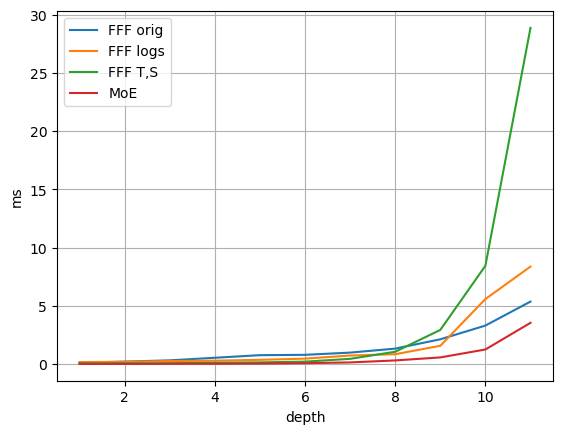

In [10]:
import matplotlib.pyplot as plt
for k,v in means.items():
    plt.plot(depths, v, label = k)
plt.ylabel('ms')
plt.xlabel('depth')
plt.grid()
plt.legend()

In [16]:
import wandb
import os
os.environ["WANDB_SILENT"]='true'
def export_to_wandb(means, depths, name='cpu d_inp=1024'):
    for k, ms in means.items():
        wandb.init(project='FFF', name=f'{name} {k}')
        for d, m in zip(depths, ms):
            wandb.log({"time": m, "depth": d})
        wandb.finish()

In [ ]:
export_to_wandb(means, depths)

# CUDA benchmarks

In [15]:
inp_sizes = (1024,)
depths = (1,2,3,4,5,6,7,8,9,10,11)
models = {"FFF orig":FFF0_probs, "FFF logs": FFF1_probs, "FFF T,S":FFF2_probs, "MoE":MoE_probs}
results = {"FFF orig":[], "FFF logs": [], "FFF T,S":[], "MoE":[]}
for m in results: results[m] =  benchmark_model(models[m], inp_sizes, depths, cuda=True)

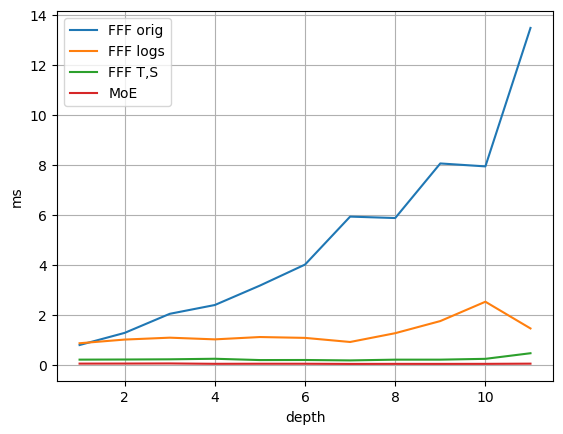

In [17]:
means = {m:L(res).map(lambda x: x.mean*1e3) for m, res in results.items()}
import matplotlib.pyplot as plt
for k,v in means.items():
    plt.plot(depths, v, label = k)
plt.ylabel('ms')
plt.xlabel('depth')
plt.grid()
plt.legend()

In [ ]:
export_to_wandb(means, depths, name='cuda d_inp=1024')